In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")

In [3]:
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [6]:
data.shape

(42, 2)

In [7]:
#Checking for null values

In [8]:
data.isnull().sum()

Quarter    0
Sales      0
dtype: int64

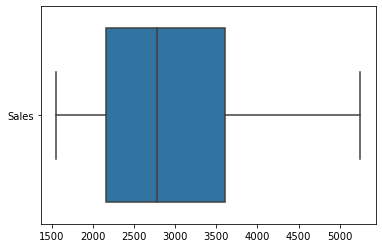

In [10]:
sns.boxplot(data=data,orient="h")

In [13]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [14]:
quarter =['Q1','Q2','Q3','Q4']

In [18]:
p = data["Quarter"][0]
p[0:2]
data['quarter']= 0

for i in range(42):
    p = data["Quarter"][i]
    data['quarter'][i]= p[0:2]

<ipython-input-18-0b4f1e88b058>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['quarter'][i]= p[0:2]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
data.head()

,Quarter,Sales,quarter
0,Q1_86,1734.827000,Q1
1,Q2_86,2244.960999,Q2
2,Q3_86,2533.804993,Q3
3,Q4_86,2154.962997,Q4
4,Q1_87,1547.818996,Q1


In [20]:
quarter_dummies = pd.DataFrame(pd.get_dummies(data['quarter']))
CocaCola = pd.concat([data,quarter_dummies],axis = 1)
CocaCola.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1,1,0,0,0


In [21]:
CocaCola["t"] = np.arange(1,43)   #time index
CocaCola["t_squared"] = CocaCola["t"]*CocaCola["t"] # for ploynomial/quadratic trend
CocaCola["log_Sales"] = np.log(CocaCola["Sales"]) # For multiplicative seasonality
CocaCola.columns

Index(['Quarter', 'Sales', 'quarter', 'Q1', 'Q2', 'Q3', 'Q4', 't', 't_squared',
       'log_Sales'],
      dtype='object')

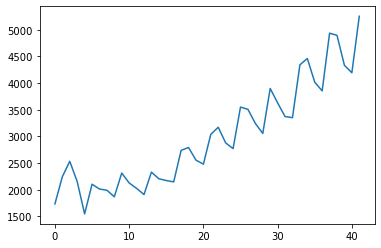

In [22]:
CocaCola.Sales.plot()
plt.show()

In [23]:
#Splitting train and test data

In [25]:
Train = CocaCola.head(34)
Test = CocaCola.tail(8)

In [27]:
#Models

In [28]:
#Linear
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  720.6137817965259


In [30]:
#Exponential
Exp = smf.ols('log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  564.9850937274292


In [31]:
#Quadratic
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  437.7455637558559


In [32]:
#Additive Seasonality
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1', 'Q2', 'Q3', 'Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  1870.1899069853293


In [33]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1', 'Q2', 'Q3', 'Q4','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 257.67172565362677


In [34]:
# Multiplicative Seasonality
Mul_sea = smf.ols('log_Sales~Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 1940.8042499186577


In [35]:
#Multiplicative Additive Seasonality

Mul_Add_sea = smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea)

RMSE Multiplicative Additive Seasonality: 400.42004584362434


In [36]:
#Tabulizing the values
data1 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data1)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,720.613782
1,rmse_Exp,564.985094
2,rmse_Quad,437.745564
3,rmse_add_sea,1870.189907
4,rmse_add_sea_quad,257.671726
5,rmse_Mult_sea,1940.804250
6,rmse_Mult_add_sea,400.420046


In [37]:
#Forecasting for next 4 quarters

In [38]:
data = [['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'],['Q2_97', 'Q2']]
print(data)
forecast = pd.DataFrame(data, columns = ['Quarter', 'quarter'])
forecast

[['Q3_96', 'Q3'], ['Q4_96', 'Q4'], ['Q1_97', 'Q1'], ['Q2_97', 'Q2']]


,Quarter,quarter
0,Q3_96,Q3
1,Q4_96,Q4
2,Q1_97,Q1
3,Q2_97,Q2


In [39]:
dummies = pd.DataFrame(pd.get_dummies(forecast['quarter']))
forecast1 = pd.concat([forecast,dummies],axis = 1)
print("After dummy\n",forecast1.head())

forecast1["t"] = np.arange(1,5)   
forecast1["t_squared"] = forecast1["t"]*forecast1["t"] 
print("\nAfter T and T-Square\n",forecast1.head())

After dummy
   Quarter quarter  Q1  Q2  Q3  Q4
0   Q3_96      Q3   0   0   1   0
1   Q4_96      Q4   0   0   0   1
2   Q1_97      Q1   1   0   0   0
3   Q2_97      Q2   0   1   0   0

After T and T-Square
   Quarter quarter  Q1  Q2  Q3  Q4  t  t_squared
0   Q3_96      Q3   0   0   1   0  1          1
1   Q4_96      Q4   0   0   0   1  2          4
2   Q1_97      Q1   1   0   0   0  3          9
3   Q2_97      Q2   0   1   0   0  4         16


In [41]:
# Forecasting using Additive Seasonality Quadratic Model
model = smf.ols('Sales~t+t_squared+Q1+Q2+Q3+Q4',data=CocaCola).fit()
pred_new  = pd.Series(model.predict(forecast1))
pred_new

forecast1["forecasted_sales"] = pd.Series(pred_new)

In [42]:
#Final sales Prediction

Final_predict = forecast1.loc[:, ['Quarter', 'forecasted_sales']] 
Final_predict

,Quarter,forecasted_sales
0,Q3_96,2180.858824
1,Q4_96,1851.383709
2,Q1_97,1635.419724
3,Q2_97,2284.261547
